In [ ]:
# general
import pandas as pd
import numpy as np
import random

# train/test split and encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# gridsearch + cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# log reg
from sklearn.linear_model import LogisticRegression

# svm
from sklearn import svm

# mlp
from sklearn.neural_network import MLPClassifier

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.metrics import RocCurveDisplay

# visualization
import matplotlib.pyplot as plt


LOADING DATA, TRAIN/TEST SPLIT, AND ONE-HOT ENCODING

In [ ]:
# load the dataset
def load_dataset(filename, numbases):
	# load the dataset as a pandas DataFrame
	data = pd.read_csv(filename)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, 1+numbases:81]
	y = dataset[:, 81]
	# format all fields as string
	X = X.astype(str)
	# reshape target to be a 2d array
	y = y.reshape((len(y), 1))
	return X, y

# load the dataset
X, y = load_dataset('agroRight.csv', 0)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (251, 80) (251, 1)
Test (63, 80) (63, 1)


In [ ]:
def prepare_inputs(X_train, X_test):
	ohe = OneHotEncoder()
	ohe.fit(X_train)
	X_train_enc = ohe.transform(X_train)
	X_test_enc = ohe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# plots accuracy vs. precision for each of the models tried in the gridsearch
def plotOptimization(results, modelName):
  x = np.array(results["mean_test_precision"].data, dtype=float)
  y = np.array(results["mean_test_accuracy"].data, dtype=float)

  plt.scatter(x,y)
  plt.xlabel("Precision")
  plt.ylabel("Accuracy")
  plt.title(modelName + " Optimization")
  plt.show
  plt.savefig(modelName + 'APgraph.png', dpi=600)

# defines refit strategy based on accuracy for gridsearch
def refit_strategy(cv_results):
  cv_results = pd.DataFrame(cv_results)
  return cv_results["mean_test_accuracy"].idxmax()

# displays an ROC curve for most accurate model found in gridsearch
def displayROC(estimator, X_train, y_train, X_test, y_test, modelName):
  estimator.fit(X_train, y_train)
  display =RocCurveDisplay.from_estimator(estimator, X_test, y_test)
  _ = display.ax_.set_title(modelName + " ROC Curve")

LOGISTIC REGRESSION

Streaming output truncated to the last 5000 lines.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Al

0.7777777777777778
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


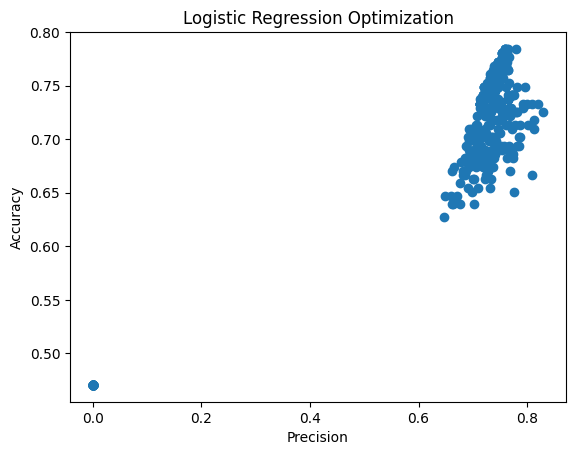

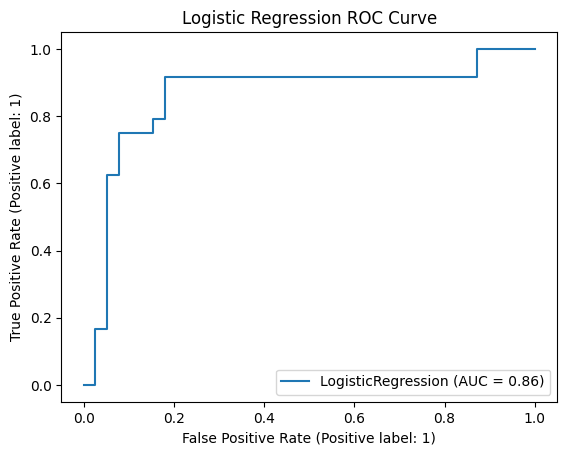

In [ ]:
LR_estimator = LogisticRegression()

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

scores = ["precision", "recall", "accuracy"]

paramList = {
    "penalty": ['l1', 'l2', 'elasticnet', None],
    "tol": [1e-4, 1e-2, 1e0, 1e1],
    "C": [1.0, 2.0, 4.0, 8.0],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "max_iter": [50, 100, 200, 500]
}

grid = GridSearchCV(LR_estimator, paramList, refit=refit_strategy, scoring=scores, cv=cv)

grid.fit(X_train_enc, y_train_enc)
results = grid.cv_results_

plotOptimization(results, "Logistic Regression")

displayROC(LR_estimator, X_train_enc, y_train_enc, X_test_enc, y_test_enc, "Logistic Regression")

LR_estimator.fit(X_train_enc, y_train_enc)

y_pred = LR_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(LR_estimator.get_params())

In [ ]:
LR_estimator.fit(X_train_enc, y_train_enc)

y_pred = LR_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(LR_estimator.get_params())

0.7777777777777778
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


SVC

0.873015873015873
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


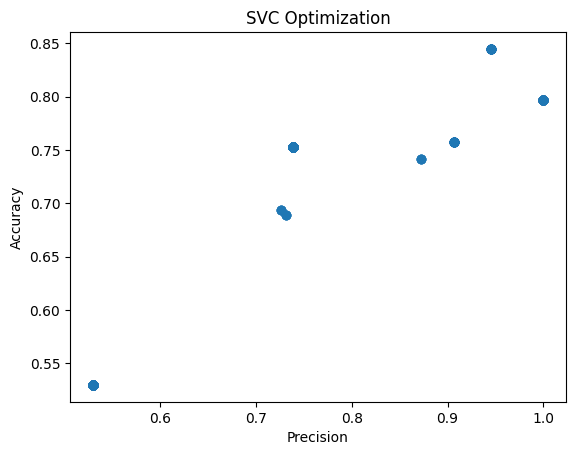

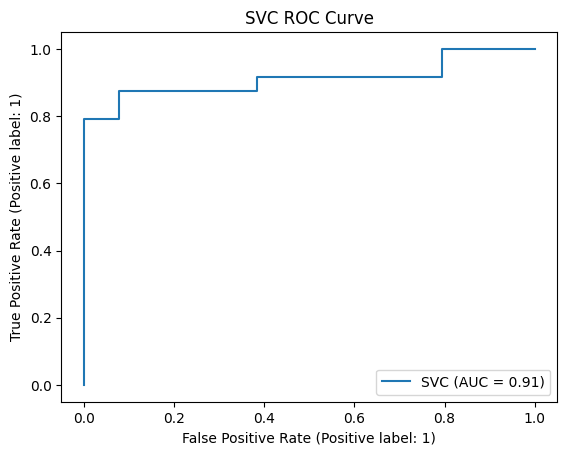

In [ ]:
SVC_estimator = svm.SVC()

scores = ["precision", "recall", "accuracy"]

paramList = {
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 1.0, 2.0, 3.0, 4.0],
    "coef0": [0.0, 1.0, 10.0, 100.0, 1000.0, 3000.0],
    "shrinking": [True, False],
    "probability": [True, False]
}

grid = GridSearchCV(SVC_estimator, paramList, refit=refit_strategy, scoring=scores)

grid.fit(X_train_enc, y_train_enc)
results = grid.cv_results_

plotOptimization(results, "SVC")

displayROC(SVC_estimator, X_train_enc, y_train_enc, X_test_enc, y_test_enc, "SVC")

SVC_estimator.fit(X_train_enc, y_train_enc)

y_pred = SVC_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(SVC_estimator.get_params())

In [ ]:
y_pred = SVC_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(SVC_estimator.get_params())

0.873015873015873
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


MLP Classifier

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

0.8412698412698413
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


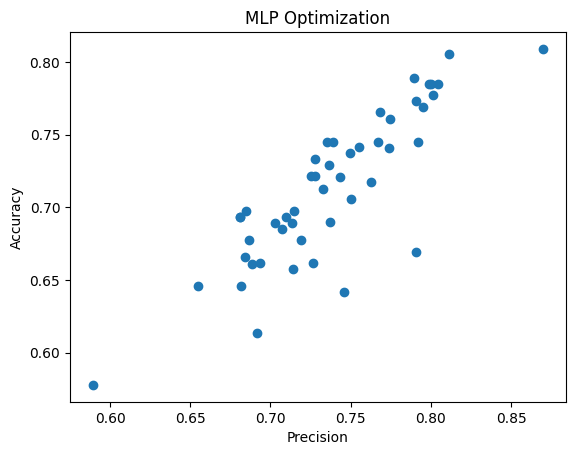

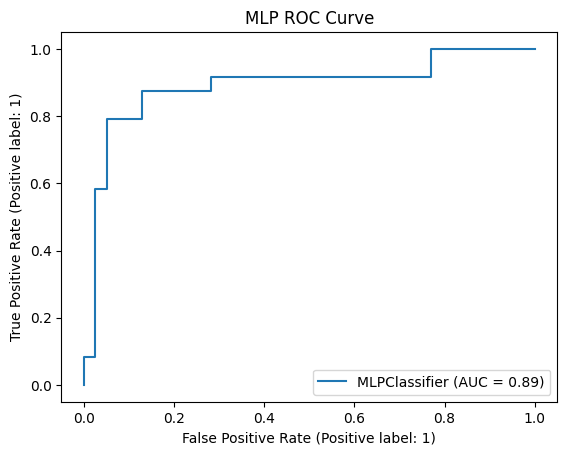

In [ ]:

from sklearn.neural_network import MLPClassifier


MLP_estimator = MLPClassifier()
scores = ["precision", "recall", "accuracy"]

paramList = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(MLP_estimator, paramList, refit=refit_strategy, scoring=scores)

grid.fit(X_train_enc, y_train_enc)
results = grid.cv_results_

plotOptimization(results, "MLP")

displayROC(MLP_estimator, X_train_enc, y_train_enc, X_test_enc, y_test_enc, "MLP")

MLP_estimator.fit(X_train_enc, y_train_enc)

y_pred = MLP_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(MLP_estimator.get_params())

In [ ]:
y_pred = MLP_estimator.predict(X_test_enc)
print(accuracy_score(y_pred, y_test_enc))

print(MLP_estimator.get_params())

0.8412698412698413
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


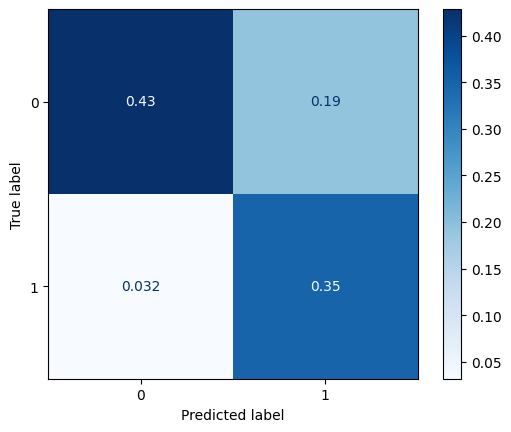

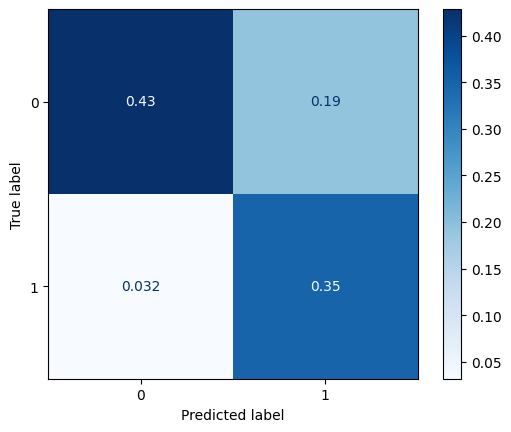

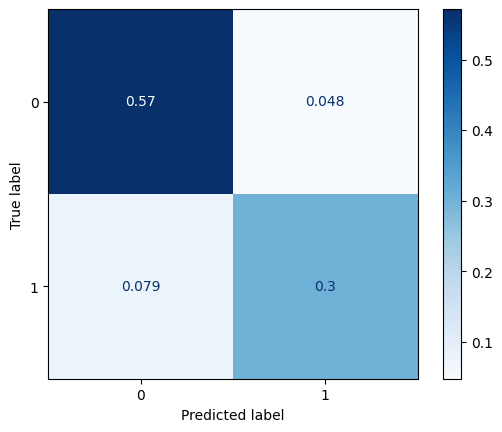

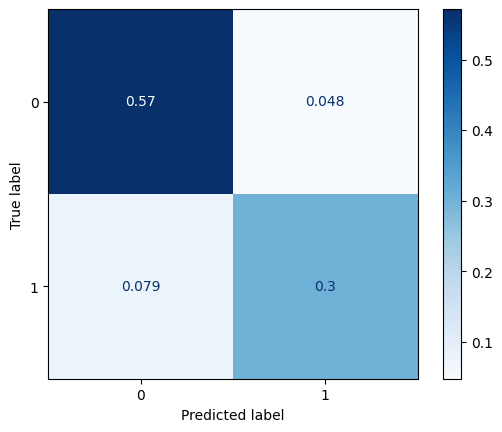

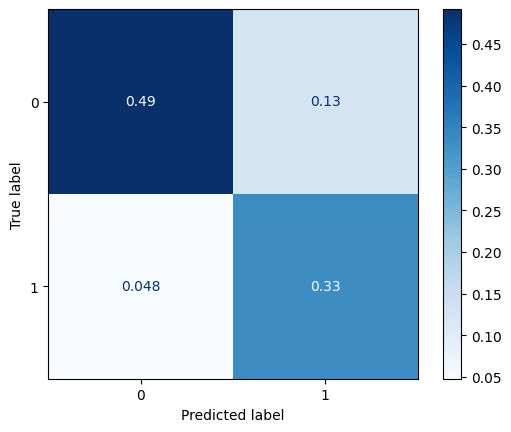

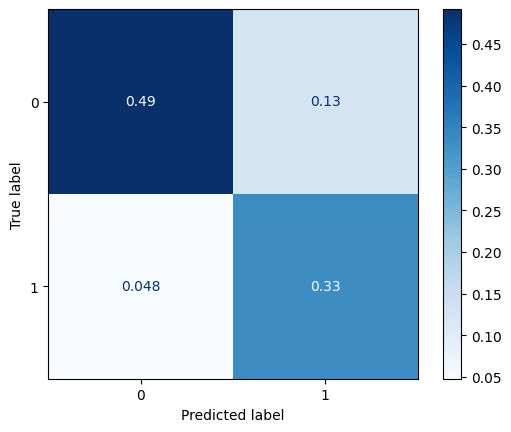

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#plots confusion matrix based on specified model, model parameters, and encoded data
def plotConfusionMatrix(model, modelParams, X_train_enc, y_train_enc, X_test_enc, y_test_enc, fileName):
  #trains model of specified type and parameters
  estimator = model.set_params(**modelParams)
  estimator.fit(X_train_enc, y_train_enc)

  #generates confusion matrix based on predictions from testing data
  predictions = estimator.predict(X_test_enc)
  #cm = confusion_matrix(y_test_enc, predictions, labels=estimator.classes_)

  #displays confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(y_test_enc, predictions,
                                                 labels=estimator.classes_,
                                                 normalize='all',
                                                 cmap='Blues')
  disp.plot(cmap = 'Blues')
  plt.savefig(fileName, dpi = 600)



#Confusion matrix for Logistic Regression
fileName = 'LRcmRight.png'
model = LogisticRegression()
modelParams = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True,
               'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto',
               'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs',
               'tol': 0.0001, 'verbose': 0, 'warm_start': False}

plotConfusionMatrix(model, modelParams, X_train_enc, y_train_enc, X_test_enc, y_test_enc, fileName)


#Confusion matrix for SVC
fileName = 'SVCcmRight.png'
model = svm.SVC()
modelParams = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None,
               'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3,
               'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False,
               'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

plotConfusionMatrix(model, modelParams, X_train_enc, y_train_enc, X_test_enc, y_test_enc, fileName)

#Confusion matrix for MLP
fileName = 'MLPcmRight.png'
model = MLPClassifier()
modelParams = {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto',
               'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08,
               'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001,
               'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10,
               'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True,
               'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False,
               'warm_start': False}

plotConfusionMatrix(model, modelParams, X_train_enc, y_train_enc, X_test_enc, y_test_enc, fileName)




